In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from transformers import pipeline, set_seed
from tqdm import tqdm
import random

In [ ]:
data = pd.read_csv('/content/Combined Data.csv')

In [ ]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
data.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [ ]:
data.dropna(inplace=True)

In [ ]:
data['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


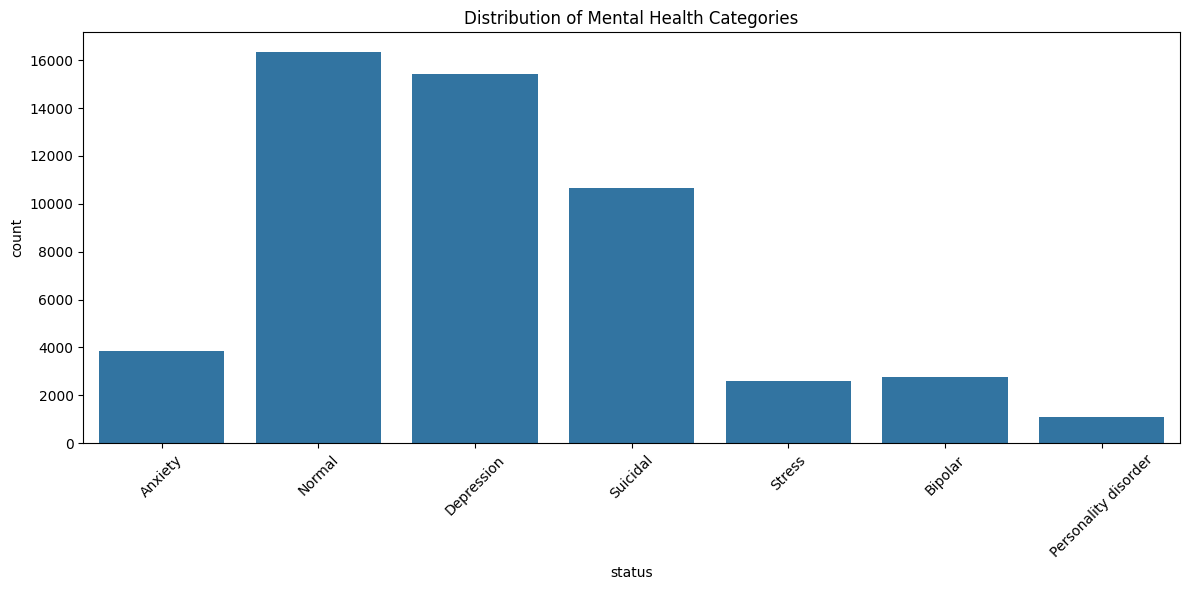

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='status', data=data)
plt.title('Distribution of Mental Health Categories')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

In [ ]:
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return new_words


In [ ]:
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


In [ ]:
def add_word(new_words):
    synonyms = []
    counter = 0
    while not synonyms and counter < 10:
        random_word = random.choice(new_words)
        synonyms = get_synonyms(random_word)
        counter += 1
    if synonyms:
        new_words.insert(random.randint(0, len(new_words)), random.choice(synonyms))


In [ ]:
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) >= 2:  # Check if enough words for swapping
            idx1, idx2 = random.sample(range(len(new_words)), 2)
            new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

In [ ]:
def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [word for word in words if random.random() > p]


In [ ]:
def eda(sentence, num_aug=4):
    sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
    words = nltk.word_tokenize(sentence)  # Tokenize into words
    augmented_sentences = []

    num_words = len(words)
    n = max(1, int(0.1 * num_words))  # Apply transformations to 10% of the words

    # Apply all 4 techniques
    augmented_sentences.append(" ".join(synonym_replacement(words, n)))
    augmented_sentences.append(" ".join(random_insertion(words, n)))
    augmented_sentences.append(" ".join(random_swap(words, n)))
    augmented_sentences.append(" ".join(random_deletion(words)))

    return augmented_sentences[:num_aug]


In [ ]:
target_count = 7000
minority_classes = ['Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
augmented_rows = []


for cls in minority_classes:
    subset = data[data['status'] == cls]
    current_count = len(subset)
    needed = target_count - current_count

    print(f"Augmenting class '{cls}' from {current_count} to {target_count} (adding {needed} samples)...")

    texts = subset['statement'].tolist()
    i = 0
    class_augmented = []
    pbar = tqdm(total=needed)
    while len(class_augmented) < needed:
        original_text = texts[i % current_count]
        augmented_texts = eda(original_text, num_aug=1)
        for aug_text in augmented_texts:
            class_augmented.append({'statement': aug_text, 'status': cls})
            pbar.update(1)
            if len(class_augmented) >= needed:
                break
        i += 1
    pbar.close()
    augmented_rows.extend(class_augmented)  # Add only after class is done


Augmenting class 'Anxiety' from 3841 to 7000 (adding 3159 samples)...


100%|██████████| 3159/3159 [00:18<00:00, 166.91it/s]


Augmenting class 'Bipolar' from 2777 to 7000 (adding 4223 samples)...


100%|██████████| 4223/4223 [00:17<00:00, 240.97it/s]


Augmenting class 'Stress' from 2587 to 7000 (adding 4413 samples)...


100%|██████████| 4413/4413 [00:10<00:00, 441.20it/s]


Augmenting class 'Personality disorder' from 1077 to 7000 (adding 5923 samples)...


100%|██████████| 5923/5923 [00:23<00:00, 247.73it/s]


In [ ]:
# Create and combine DataFrames
augmented_df = pd.DataFrame(augmented_rows)
balanced_df = pd.concat([data, augmented_df], ignore_index=True)
print(balanced_df['status'].value_counts())

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  7000
Stress                   7000
Bipolar                  7000
Personality disorder     7000
Name: count, dtype: int64


In [ ]:
augmented_df['statement'][5]

'every break you must be nervous like something is wrong simply what the heck'

In [ ]:
data['statement'][100]

'Feeling a little anxious today.'

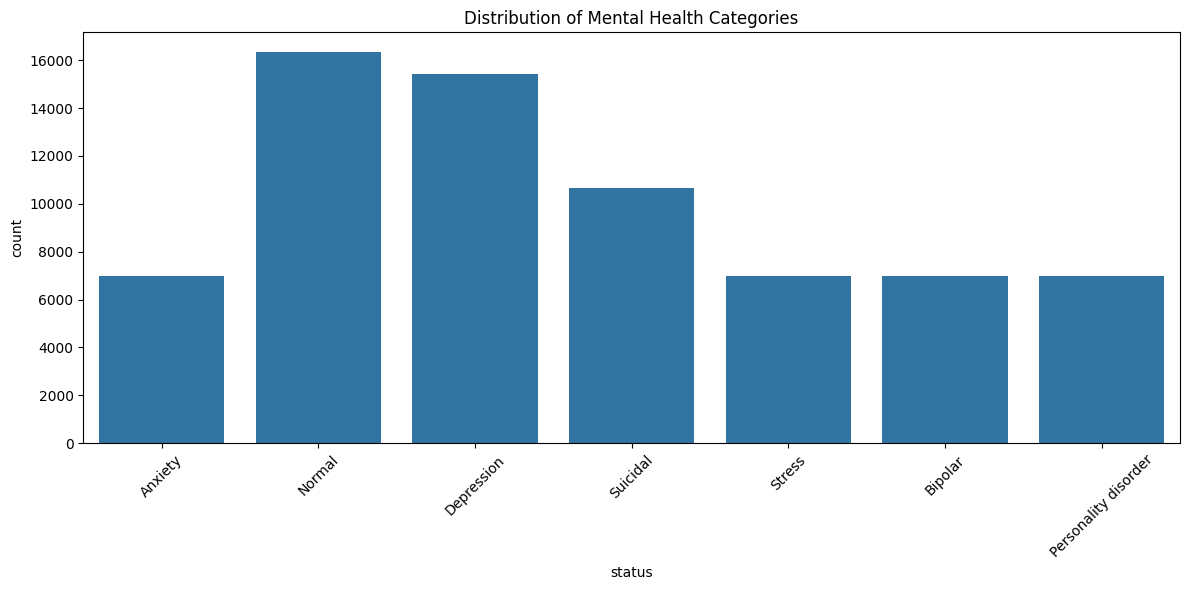

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='status', data=balanced_df)
plt.title('Distribution of Mental Health Categories')
plt.xticks(rotation=45)
plt.tight_layout()

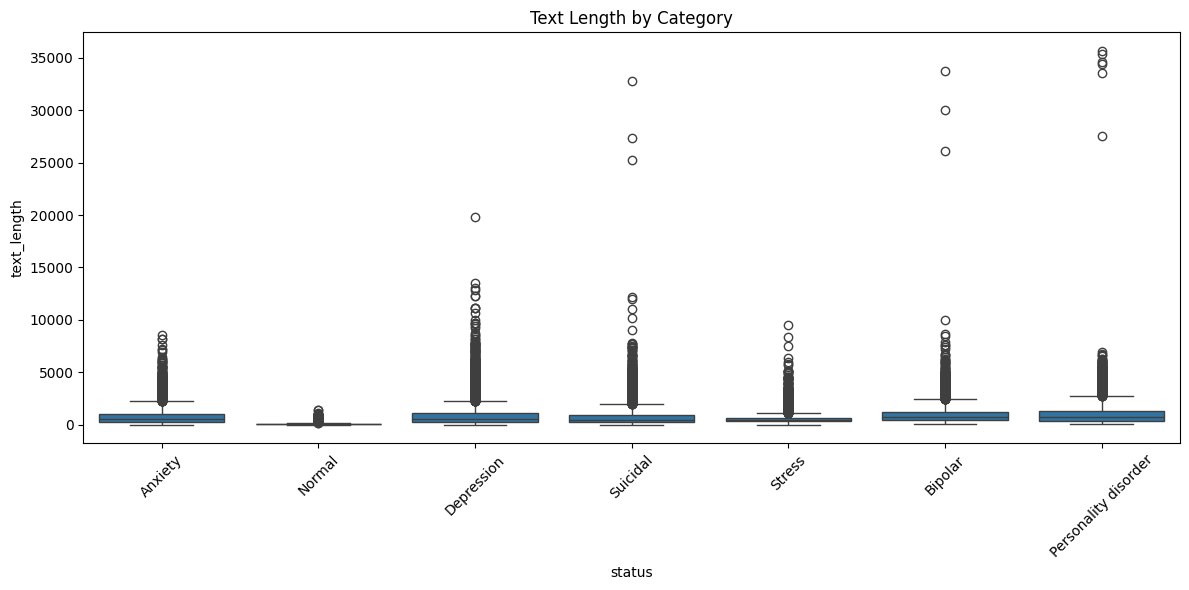

In [ ]:
# Text length analysis
balanced_df['text_length'] = balanced_df['statement'].apply(len)
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='text_length', data=balanced_df)
plt.title('Text Length by Category')
plt.xticks(rotation=45)
plt.tight_layout()

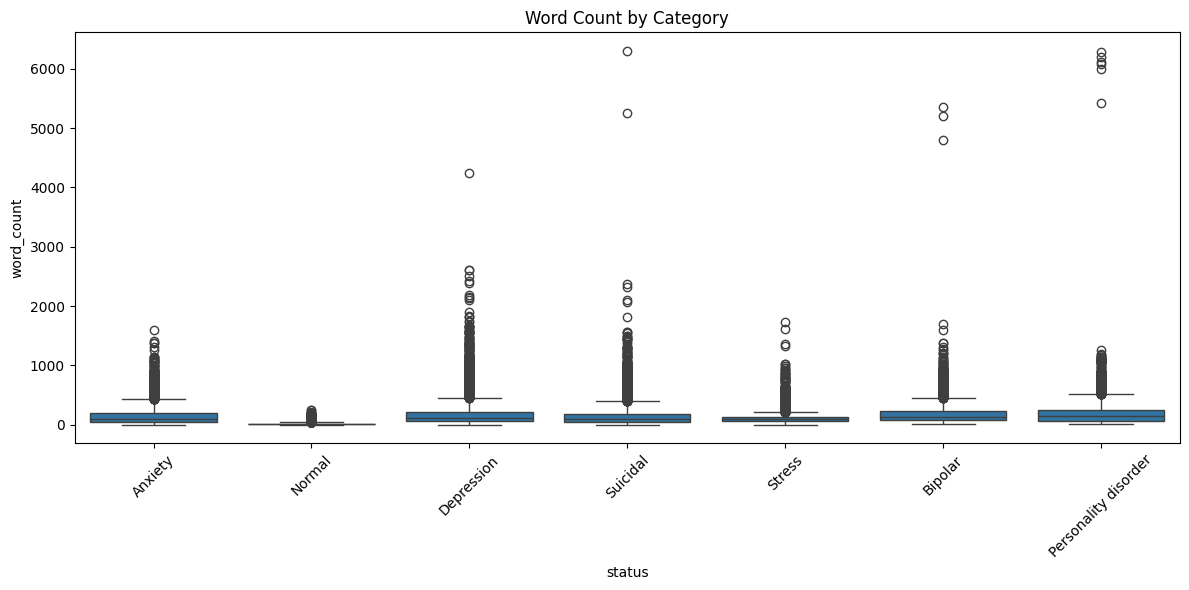

In [ ]:
# Word count analysis
balanced_df['word_count'] = balanced_df['statement'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='word_count', data=balanced_df)
plt.title('Word Count by Category')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [ ]:
def prepare_data(df):
    print("Preprocessing text data...")
    df['clean_statement'] = df['statement'].apply(text_preprocessing)

    label_mapping = {label: idx for idx, label in enumerate(df['status'].unique())}
    df['label'] = df['status'].map(label_mapping)

    X_train, X_temp, y_train, y_temp = train_test_split(
        df['clean_statement'],
        df['label'],
        test_size=0.3,
        random_state=42,
        stratify=df['label']
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, label_mapping

In [ ]:
def prepare_text_for_dl(X_train, X_val, X_test, max_words=6000, max_len=128):
    # Tokenization
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    return X_train_pad, X_val_pad, X_test_pad, tokenizer

In [ ]:
def build_lstm_model(vocab_size, embedding_dim, max_len, num_classes):

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

In [ ]:
def train_deep_learning_model(X_train_pad, y_train, X_val_pad, y_val, vocab_size, num_classes, max_len):

    embedding_dim = 256

    model = build_lstm_model(vocab_size, embedding_dim, max_len, num_classes)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    # Train model
    print("\nTraining Bidirectional LSTM Model...")
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    # plt.savefig('dl_training_history.png')

    return model, history

In [ ]:
def evaluate_model(model, X_test_pad, y_test, label_mapping):

    loss, accuracy = model.evaluate(X_test_pad, y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    y_pred_proba = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Classification report
    reversed_mapping = {v: k for k, v in label_mapping.items()}
    target_names = [reversed_mapping[i] for i in range(len(label_mapping))]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

    return y_pred, y_pred_proba

In [ ]:
def main(file_path):

    print("Starting Mental Health Classification Pipeline...")

    X_train, X_val, X_test, y_train, y_val, y_test, label_mapping = prepare_data(balanced_df)

    max_words = 6000
    max_len = 128
    X_train_pad, X_val_pad, X_test_pad, tokenizer = prepare_text_for_dl(
        X_train, X_val, X_test, max_words, max_len
    )

    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    num_classes = len(label_mapping)
    dl_model, history = train_deep_learning_model(
        X_train_pad, y_train, X_val_pad, y_val, vocab_size, num_classes, max_len
    )

    # Evaluate deep learning model
    y_pred_dl, y_pred_proba = evaluate_model(dl_model, X_test_pad, y_test, label_mapping)
    dl_accuracy = accuracy_score(y_test, y_pred_dl)

Starting Mental Health Classification Pipeline...
Preprocessing text data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Bidirectional LSTM Model...
Epoch 1/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.5024 - loss: 1.3064 - val_accuracy: 0.7459 - val_loss: 0.6988
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.7712 - loss: 0.6303 - val_accuracy: 0.7618 - val_loss: 0.6342
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8251 - loss: 0.4541 - val_accuracy: 0.7953 - val_loss: 0.5579
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8487 - loss: 0.3705 - val_accuracy: 0.8060 - val_loss: 0.5252
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8679 - loss: 0.3126 - val_accuracy: 0.8101 - val_loss: 0.5392
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8808 - loss: 0.2750 - val_accuracy: 0.8087 - val_loss: 0.5406
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.8947 - loss: 0.2296 - val_accuracy: 0.8136 - val_loss: 0.5720
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy

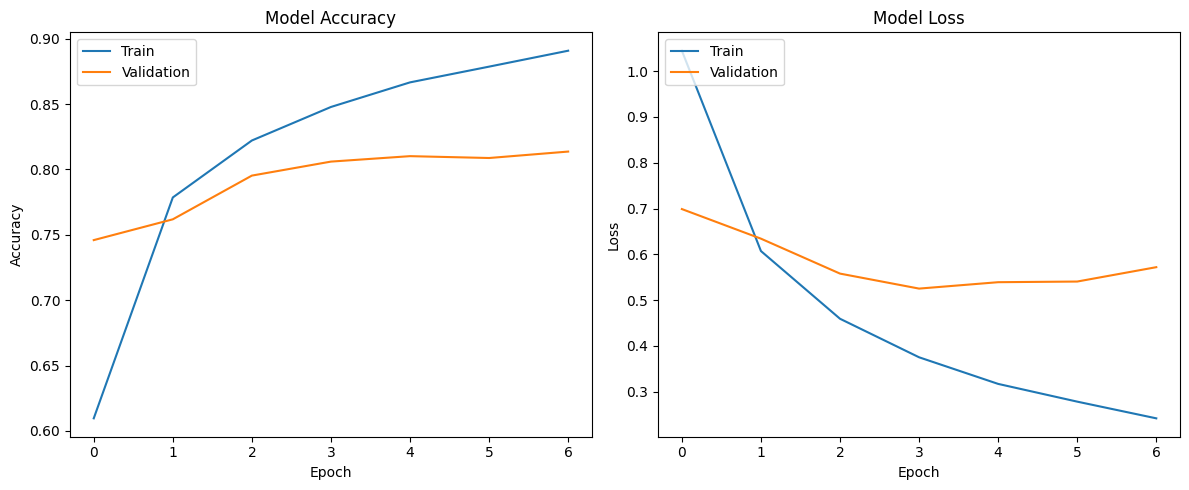

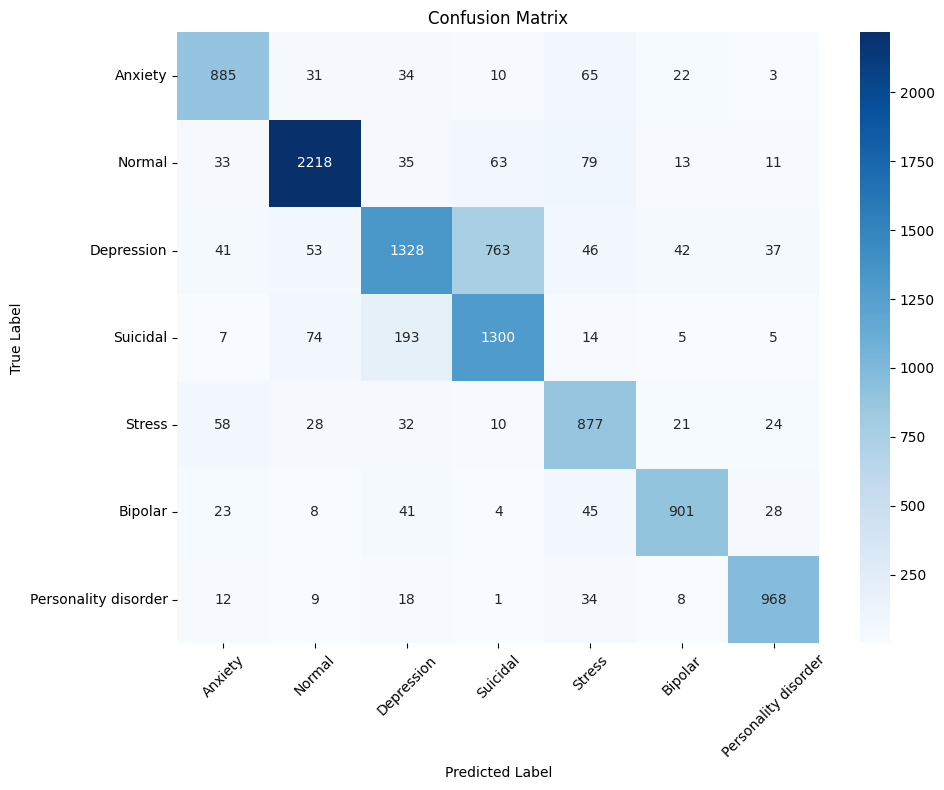

In [ ]:
if __name__ == "__main__":
    main(balanced_df)